In [32]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import segyio # não sendo usada
import scipy.signal
import scipy.interpolate
import pylops
import seaborn as sns
import scipy.linalg
from numpy.linalg import inv
import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

In [33]:
print('Numpy', np.__version__)
print('Scipy', scipy.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', matplotlib.__version__)
print('Pylops', pylops.__version__)

Numpy 1.26.3
Scipy 1.11.4
Pandas 2.1.4
Matplotlib 3.8.2
Pylops 2.1.0


In [3]:
eoceno = pd.read_csv("Superficies/EocenoSuperior_SubvolBackground_Time.dat",
                     sep='\s+', skiprows=0, usecols=(0, 1, 2), names=['X', 'Y', 'Z'])

In [4]:
paleoceno = pd.read_csv("Superficies/Paleoceno_SubvolBackground_Time.dat",
                        sep='\s+', skiprows=0, usecols=(0, 1, 2), names=['X', 'Y', 'Z'])

In [ ]:
xl_start = np.min(eoceno['Y'])
xl_end = np.max(eoceno['Y'])

In [5]:
amp = np.load("Sismica/sismica_497.npy")
mback = np.load("Impedancia/lowfrequency_497.npy")
wav = np.load("Wavelets/wav_avg.npy")

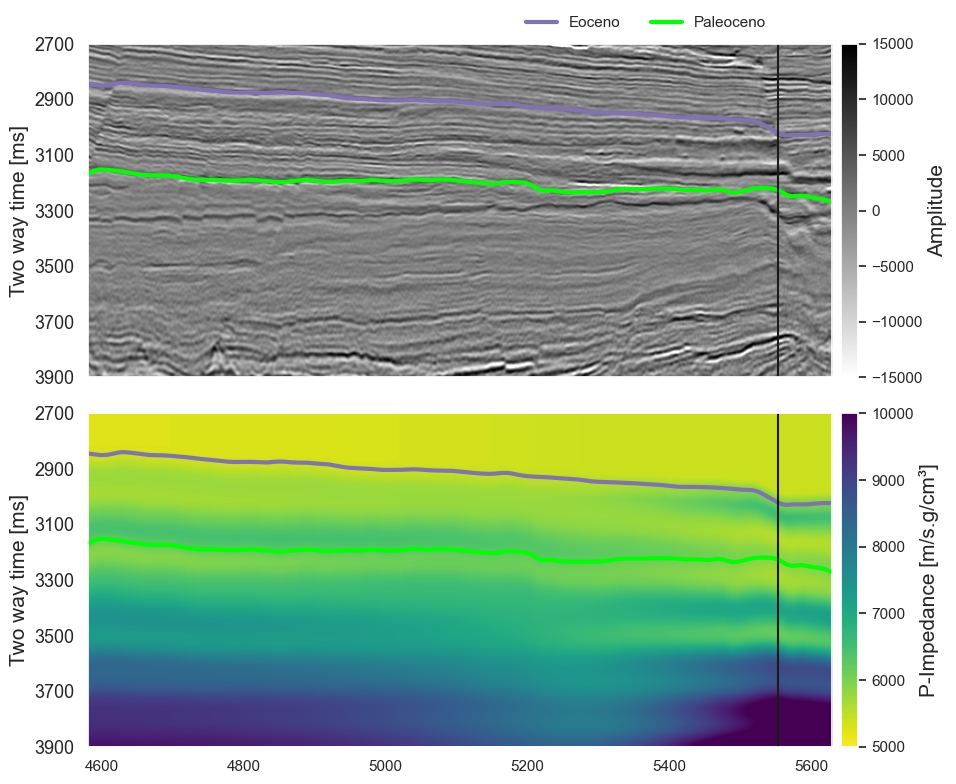

In [49]:
# Seismic section of well 55

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

c=axs[0].imshow(amp.T, # Amplitude
                aspect='auto',
                cmap='gray_r',
                vmin=-15000,
                vmax=15000,
                extent=[xl_start, xl_end, 7000, 0])
plt.colorbar(c, ax=axs[0], pad=0.01).set_label('Amplitude', size=15)

c=axs[1].imshow(mback.T, aspect='auto', cmap='viridis_r', vmin=5000, vmax=10000, extent=[xl_start, xl_end, 7000, 0])
plt.colorbar(c, ax=axs[1], pad=0.01).set_label('P-Impedance [m/s.g/cm³]', size=15)


for ax in [axs[0], axs[1]]:
    ax.grid(False)
    ax.set_ylim(3900, 2700)
    #ax.set_xlim(il_start, il_end)
    ax.set_yticks(np.arange(2700, 3901, 200))
    ax.set_yticklabels(np.arange(2700, 3901, 200), size=13)
    ax.plot(eoceno.loc[eoceno.X == 2862].Y, eoceno.loc[eoceno.X == 2862].Z,
             color='m', lw=3.0, label='Eoceno')
    ax.plot(paleoceno.loc[paleoceno.X == 2862].Y, paleoceno.loc[paleoceno.X == 2862].Z,
             color='lime', lw=3.0, label='Paleoceno')

    ax.set_ylabel("Two way time [ms]", fontsize=15)

    ax.axvline(x=5553, color='k')

axs[0].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.75, 1.0), facecolor='white', edgecolor='white')
axs[0].set_xticks([])
plt.tight_layout()
#plt.savefig('Figures/lowfrequency_497.png', dpi=200, bbox_inches='tight')

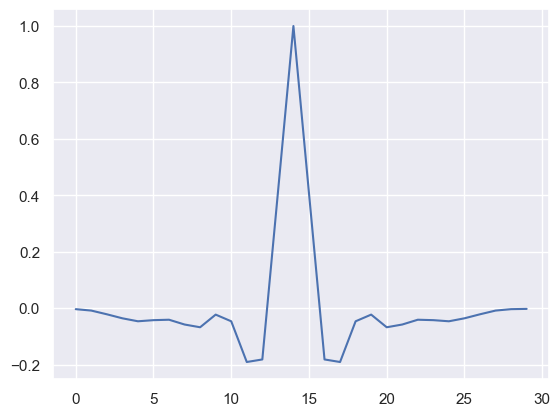

In [50]:
plt.plot(wav)

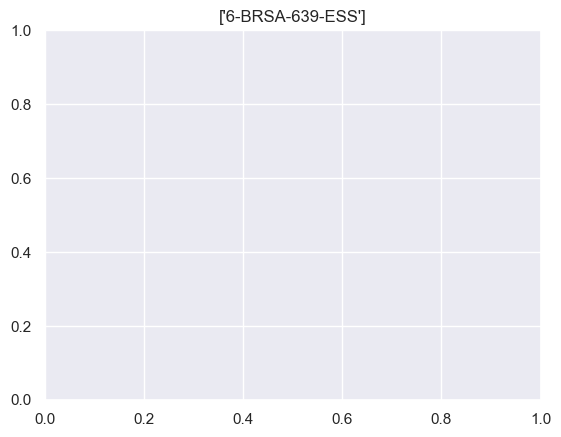

In [51]:
path = "Pocos/IP_UPS/"

df = pd.DataFrame()
names = ['Depth', 'VP', 'RHO', 'VP_4Hz', 'RHO_4Hz', 'VP_6Hz', 'RHO_6Hz',
         'VP_8Hz', 'RHO_8Hz', 'IP', 'IP_4Hz', 'IP_6Hz', 'IP_8Hz']

for file in os.listdir(path):
    well = pd.read_csv(path+file, sep='\s+', skiprows=1, names=names)
    # Replacing nans
    well.replace(1e30, np.nan, inplace=True)
    # Naming well
    well['WELL'] = file.split('_')[0]
    tdr = pd.read_csv(f'Pocos/TimeVsDepth/{file.split("_")[0]}.dat', skiprows=14, sep='\s+',
                      names=['MD', 'TVD', 'TVDSS', 'TWT', 'VINT'])
    interp_tdr = scipy.interpolate.interp1d(tdr['MD'], tdr['TWT'], fill_value='extrapolate', bounds_error=False)
    t_well = interp_tdr(well.Depth)

    new_samples = np.arange(2700, 3900, 4)
    interp2 = scipy.interpolate.interp1d(t_well, well.IP, bounds_error=False, fill_value='extrapolate')
    ip_ups = interp2(new_samples)
    ip_ups = scipy.ndimage.gaussian_filter(ip_ups, sigma=0.5)

    arr = np.array([new_samples, ip_ups])
    nwell = pd.DataFrame(arr.T, columns=['TWT', 'IP_UPS'])
    nwell['WELL'] = file.split('_')[0]
    nwell['IP_UPS'] = nwell['IP_UPS'].fillna(method='bfill').fillna(method='ffill')
    # plt.title(nwell['WELL'].unique())
    # plt.plot(nwell['IP_UPS'])
    # plt.show()
    # Concatenate
    df = pd.concat([df, nwell], ignore_index=True)

(1051, 1051)


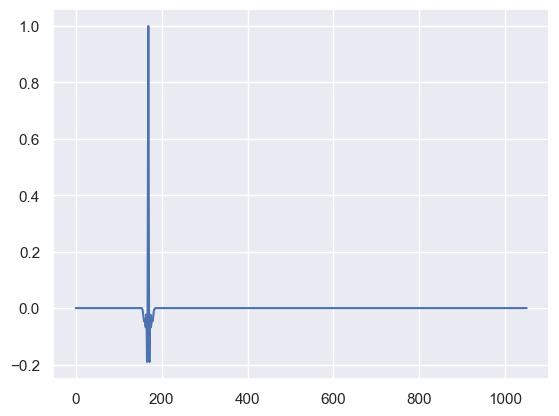

In [47]:
nd = len(mback) # impedancia
ns = len(wav) # wavelet

S = scipy.linalg.toeplitz(np.append(wav, np.zeros(2*nd-ns)), np.zeros(nd))[(ns)//2:nd+(ns)//2]
print(np.shape(S))
plt.plot(S[:,170])

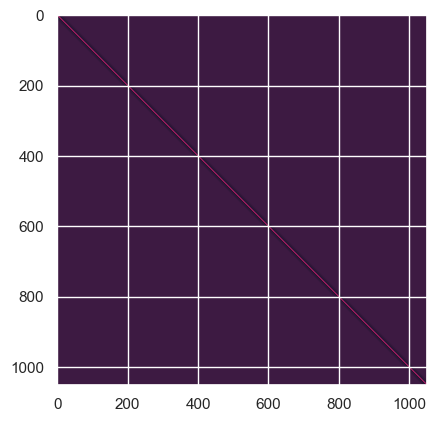

In [73]:
# plt.imshow(matder @ np.log(mback))
plt.imshow(S)

In [77]:
S.T

array([[ 0.40777161, -0.18207474, -0.1911126 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.40777161, -0.18207474, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.4077711 ,  1.        ,  0.40777161, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.40777161,
        -0.18207474, -0.1911126 ],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.40777161, -0.18207474],
       [ 0.        ,  0.        ,  0.        , ...,  0.4077711 ,
         1.        ,  0.40777161]])

In [86]:
nd = len(mback) # impedancia
ns = len(wav) # wavelet

S = scipy.linalg.toeplitz(np.append(wav, np.zeros(2*nd-ns)), np.zeros(nd))[(ns)//2:nd+(ns)//2]
print(S)
matder = np.zeros(shape=(nd,nd))

for i in range(nd):
  matder[i][i] = -1
  if i<nd-1:
    matder[i][i+1] = 1
  else:
    matder[i][i] = 0
    
print(f"Matder {matder}")

refl = 0.5 * matder @ np.log(mback)
traco = S @ refl

print(f"refl {refl}")
print(f"traco {traco}")

def inv_normaL1(dobs, G, max_iter,miL1=0.1):
    """
    Funcao para calcular os parâmetros usando a solucao com norma L1 tanto no resíduo quanto no modelo de parâmetros (método IRLS)
    Dados de entrada:
        d = dados observados
        G = matriz de modelagem direta
    Output:
        m = parametros
    """
    a , b = np.shape(G)
    R = np.eye(a)
    Rm = np.eye(b)
    
    for x in range(max_iter):
        
        m = inv(G.T @ R @ G + miL1*Rm) @ G.T @ R @ dobs
        r = G @ m - dobs
        np.fill_diagonal(R, 1/np.absolute(r+0.0001), wrap=True)
        np.fill_diagonal(Rm, 1/np.absolute(m+0.0001), wrap=True)
          
    return m
  
  
m = inv_normaL1(traco, refl, 10)


[[ 0.40777161  1.          0.4077711  ...  0.          0.
   0.        ]
 [-0.18207474  0.40777161  1.         ...  0.          0.
   0.        ]
 [-0.1911126  -0.18207474  0.40777161 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.40777161  1.
   0.4077711 ]
 [ 0.          0.          0.         ... -0.18207474  0.40777161
   1.        ]
 [ 0.          0.          0.         ... -0.1911126  -0.18207474
   0.40777161]]
Matder [[-1.  1.  0. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ...  0. -1.  1.]
 [ 0.  0.  0. ...  0.  0.  0.]]
refl [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
traco [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan

In [82]:
I = np.eye(nd)

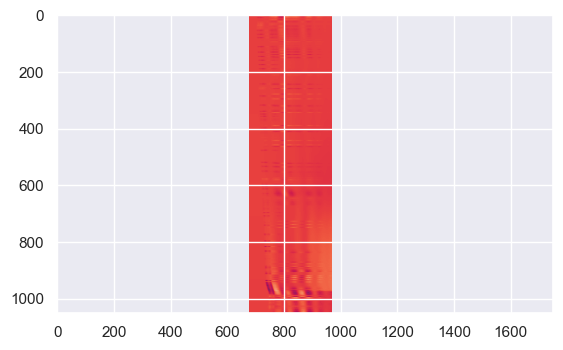

In [93]:
def inv_normaL2(dobs, G, L, miL2):
    
    """
    Funcao para calcular os parâmetros usando a solucao com norma L2
    Dados de entrada:
        d = dados observados
        G = matriz de modelagem direta
        
    Output:
        m = parametros
    """
    m = inv(G.T @ G + miL2* L.T @ L) @ G.T @ dobs
        
    return m

m2 = inv_normaL2(dobs = traco, G = S, L = I, miL2 = 0.0001)
plt.imshow(m2)

In [89]:
print("traco", np.any(traco[~np.isnan(traco)] != 0))
print("m", np.any(m[~np.isnan(m)] != 0))
print("m", np.any(m2[~np.isnan(m2)] != 0))

traco True
m False
m True


In [79]:
amp_ls = amp.copy()
mback_ls = mback.copy()

In [81]:
# Inverting at well 55 inline

amp_ls = amp[:, 675:975].T
mback_ls = np.log(mback[:, 675:975].T)

print("Shape of data [n_samples, n_traces]:", amp_ls.shape)

Shape of data [n_samples, n_traces]: (300, 1051)


In [82]:
# Wavelet operator
nz, nx = amp_ls.shape
PPop = pylops.avo.poststack.PoststackLinearModelling(wav/2,
                                                     nt0=nz,
                                                     spatdims=nx,
                                                     explicit=True)

# Trace-by-trace
minv_tbt, _ = pylops.optimization.leastsquares.normal_equations_inversion(
    Op=PPop,
    y=amp_ls.ravel() / 30000,
    Regs=None,
    epsI=5e-1,
    x0=mback_ls.ravel(),
    engine='scipy',
    **dict(maxiter=1000))
minv_tbt = np.exp(mback_ls + minv_tbt.reshape(nz, nx))



In [83]:
img = np.tile(df.loc[df.WELL=='6-BRSA-497-ESS'].IP_UPS, (100, 1))

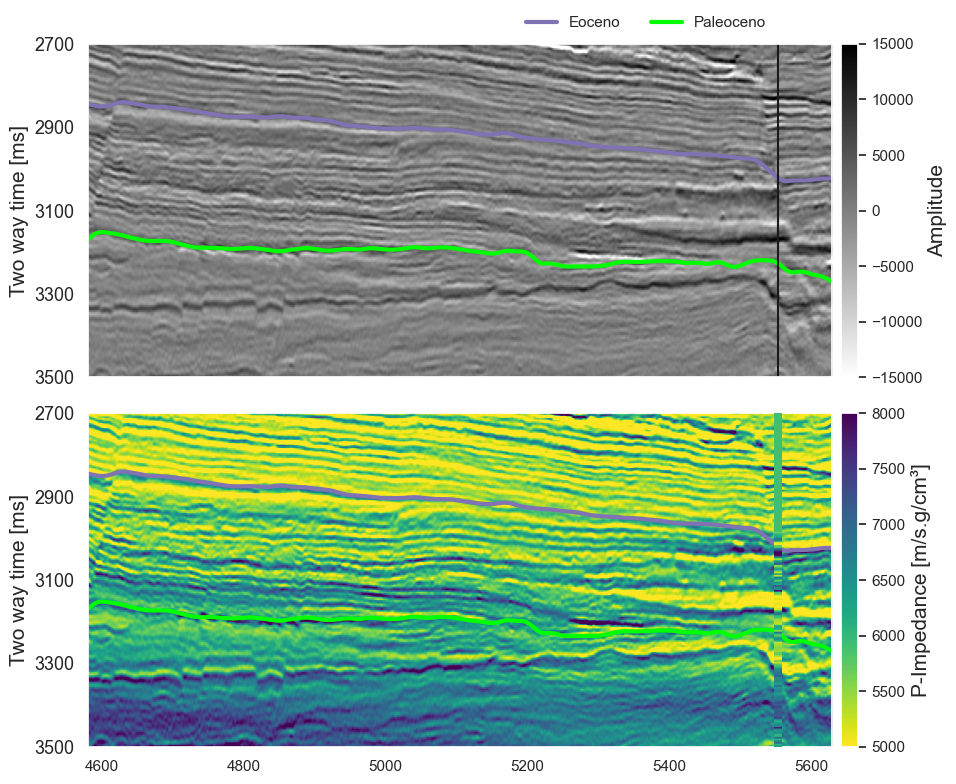

In [84]:
# Seismic section of well 55

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

c=axs[0].imshow(amp_ls, aspect='auto', cmap='gray_r', vmin=-15000, vmax=15000, extent=[xl_start, xl_end, 3900, 2700])
plt.colorbar(c, ax=axs[0], pad=0.01).set_label('Amplitude', size=15)

c=axs[1].imshow(minv_tbt, aspect='auto', cmap='viridis_r', vmin=5000, vmax=8000, extent=[xl_start, xl_end, 3900, 2700])
plt.colorbar(c, ax=axs[1], pad=0.01).set_label('P-Impedance [m/s.g/cm³]', size=15)
axs[1].imshow(img.T, aspect='auto', cmap='viridis_r', vmin=5000, vmax=8000,
             extent=(5553-5, 5553+5, 3900, 2700), zorder=20)

for ax in [axs[0], axs[1]]:
    ax.grid(False)
    ax.set_ylim(3500, 2700)
    #ax.set_xlim(il_start, il_end)
    ax.set_yticks(np.arange(2700, 3501, 200))
    ax.set_yticklabels(np.arange(2700, 3501, 200), size=13)
    ax.plot(eoceno.loc[eoceno.X == 2862].Y, eoceno.loc[eoceno.X == 2862].Z,
             color='m', lw=3.0, label='Eoceno')
    ax.plot(paleoceno.loc[paleoceno.X == 2862].Y, paleoceno.loc[paleoceno.X == 2862].Z,
             color='lime', lw=3.0, label='Paleoceno')

    ax.set_ylabel("Two way time [ms]", fontsize=15)

    ax.axvline(x=5553, color='k')

axs[0].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.75, 1.0), facecolor='white', edgecolor='white')
axs[0].set_xticks([])
plt.tight_layout()

(4000.0, 10000.0)

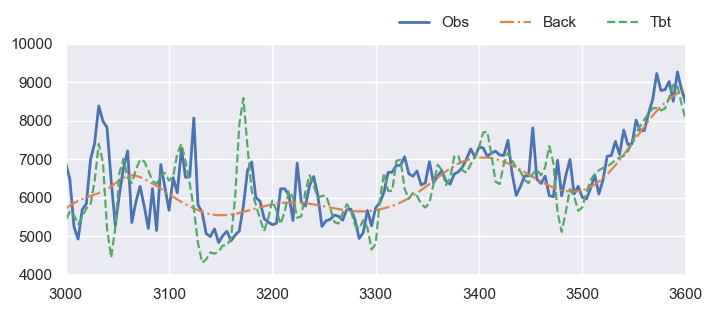

In [86]:
plt.figure(figsize=(8, 3))

plt.plot(df.loc[df.WELL=='6-BRSA-497-ESS'].TWT, df.loc[df.WELL=='6-BRSA-497-ESS'].IP_UPS, label='Obs', lw=2.0)
plt.plot(df.loc[df.WELL=='6-BRSA-497-ESS'].TWT, np.exp(mback_ls[:, 5553-xl_start]), label='Back', lw=1.6, ls='-.')
plt.plot(df.loc[df.WELL=='6-BRSA-497-ESS'].TWT, minv_tbt[:, 5553-xl_start], label='Tbt', lw=1.6, ls='--')
#plt.plot(new_twt, minv_hop[:, 1469-new_xl_start], label='Hor', lw=1.6, ls='--')
#plt.plot(new_twt, minv_dop[:, 1469-new_xl_start], label='Dir', lw=1.6, ls='--')
#plt.plot(new_twt, bsd[1269 - new_il_start, 1469-new_xl_start, :], label='Petrel', lw=1.6, ls='--')

plt.legend(loc='lower right', bbox_to_anchor=(1.0, 1.0), edgecolor='w', facecolor='w', ncol=5)

plt.xlim(3000, 3600)
plt.ylim(4000, 10000)
#plt.savefig('Figures/inversion_497_well.png', dpi=200, bbox_inches='tight')